## Analysis of pos_ache_inhibitors Dataset

The dataset is a merge of MassBank dataset and structural list of compounds by EFSA.

In [1]:
import os
os.chdir("..")
print(os.getcwd())

from matchms.importing import load_from_mgf

/Users/rosinatorres/Documents/PhD/Project/Code/MS2LDA/MS2LDA


In [2]:
from rdkit.Chem.inchi import MolFromInchi
from rdkit import DataStructs
from rdkit.Chem import AllChem
fpgen = AllChem.GetRDKitFPGenerator()

In [3]:
from matplotlib import pyplot as plt

### Loading the dataset into matchms

In [4]:
# Loading the dataset into matchms
spectra_path = "test_data/pos_ache_inhibitors_pesticides.mgf"
spectra = load_from_mgf(spectra_path)
spectra = list(load_from_mgf(spectra_path))

In [5]:
# retrieving inchis from spectra to convert them into rdkit.mol.objects
inchis = []
nominal_masses = []
for spectrum in spectra:
    inchi = spectrum.get("inchi")
    inchis.append(inchi)
    nominal_mass = spectrum.get("nominal_mass")
    nominal_masses.append(int(nominal_mass))

In [8]:
inchis

['InChI=1S/C5H12NO3PS2/c1-6-5(7)4-12-10(11,8-2)9-3/h4H2,1-3H3,(H,6,7)',
 'InChI=1S/C12H21N2O3PS/c1-6-15-18(19,16-7-2)17-11-8-10(5)13-12(14-11)9(3)4/h8-9H,6-7H2,1-5H3',
 'InChI=1S/C9H11Cl3NO3PS/c1-3-14-17(18,15-4-2)16-9-7(11)5-6(10)8(12)13-9/h5H,3-4H2,1-2H3',
 'InChI=1S/C12H15NO3/c1-12(2)7-8-5-4-6-9(10(8)16-12)15-11(14)13-3/h4-6H,7H2,1-3H3,(H,13,14)',
 'InChI=1S/C2H8NO2PS/c1-5-6(3,4)7-2/h1-2H3,(H2,3,4)',
 'InChI=1S/C10H19O6PS2/c1-5-15-9(11)7-8(10(12)16-6-2)19-17(18,13-3)14-4/h8H,5-7H2,1-4H3',
 'InChI=1S/C5H12NO3PS2/c1-6-5(7)4-12-10(11,8-2)9-3/h4H2,1-3H3,(H,6,7)',
 'InChI=1S/C12H15NO3/c1-12(2)7-8-5-4-6-9(10(8)16-12)15-11(14)13-3/h4-6H,7H2,1-3H3,(H,13,14)',
 'InChI=1S/C5H12NO3PS2/c1-6-5(7)4-12-10(11,8-2)9-3/h4H2,1-3H3,(H,6,7)',
 'InChI=1S/C10H19O6PS2/c1-5-15-9(11)7-8(10(12)16-6-2)19-17(18,13-3)14-4/h8H,5-7H2,1-4H3',
 'InChI=1S/C10H19O6PS2/c1-5-15-9(11)7-8(10(12)16-6-2)19-17(18,13-3)14-4/h8H,5-7H2,1-4H3',
 'InChI=1S/C5H12NO3PS2/c1-6-5(7)4-12-10(11,8-2)9-3/h4H2,1-3H3,(H,6,7)',
 'InChI=1S/C1

In [24]:
import csv
# Define the file name
file_name = "test_datatable.tsv"

# Write inches to the TSV file
with open(file_name, 'w', newline='') as tsvfile:
    writer = csv.writer(tsvfile, delimiter='\t')
    for inchi in inchis:
        writer.writerow([inchi])

In [6]:
mols = [MolFromInchi(inchi) for inchi in inchis]

### Database size

In [7]:
print(len(mols))

705


---

### Mass distribution

Below you can see the mass distribution of the compounds in the dataset.

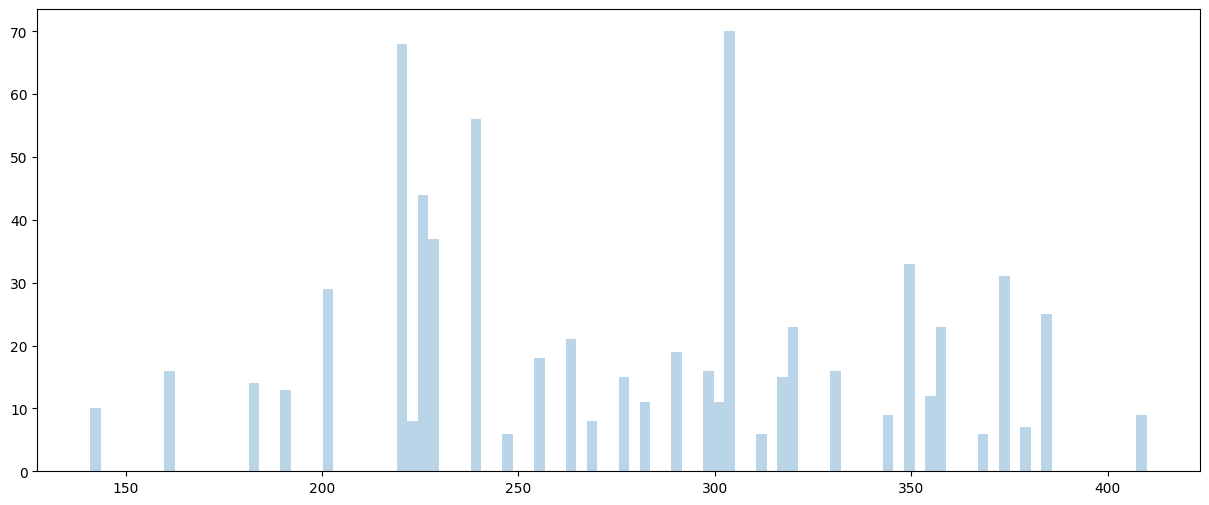

In [9]:
plt.figure(figsize=(15,6))
plt.hist(nominal_masses, bins=100, alpha=0.3)
plt.show()

### Mol similarity based on fingerprints

In the following section fingerprints of all molecules in the dataset are generated and then the tanimoto score of all pairs (AB only, not AB and BA) are calculated and visualized in a histogram.

In [10]:
# standard rdkit fingperprints (default with 1024 bits)
fps = [fpgen.GetFingerprint(mol) for mol in mols]

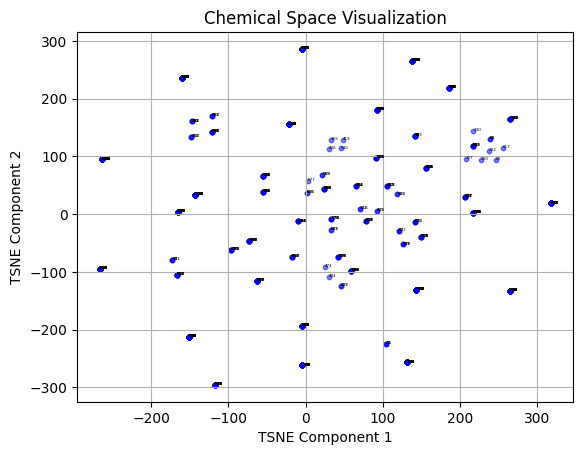

In [22]:
import numpy as np
from sklearn.manifold import TSNE

# Compute Tanimoto similarity matrix
def calculate_similarity_matrix(fps):
    num_fps = len(fps)
    similarity_matrix = np.zeros((num_fps, num_fps))
    for i, fp_i in enumerate(fps):
        for j in range(i, num_fps):
            similarity = DataStructs.TanimotoSimilarity(fp_i, fps[j])
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity
    return similarity_matrix

# Assuming 'fps' and 'inchis' are defined elsewhere
# molecules_list = [MolFromInchi(inchi) for inchi in inchis]

similarity_matrix = calculate_similarity_matrix(fps)

# Perform dimensionality reduction
#tsne = TSNE(n_components=2)
#chemicalspace = tsne.fit_transform(similarity_matrix)

pca = PCA(n_components=2)
chemicalspace_pca = pca.fit_transform(similarity_matrix)


# Plot chemical space
plt.scatter(chemicalspace[:, 0], chemicalspace[:, 1], s=10, c='blue', alpha=0.5)

# Add labels for each point
for i, (x, y) in enumerate(chemicalspace):
    plt.text(x, y, str(i), fontsize=3)

plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title('Chemical Space Visualization')
plt.grid(True)
plt.show()

In [32]:
from itertools import combinations

In [33]:
# two pair fingerprint combinations
fps_combinations = combinations(fps, 2)

In [34]:
# calculation of tanimoto scores
tanimoto_scores = []
for fp1, fp2 in fps_combinations:
    tanimoto_score = DataStructs.TanimotoSimilarity(fp1,fp2)
    tanimoto_scores.append(tanimoto_score)

In [35]:
import matplotlib.pyplot as plt

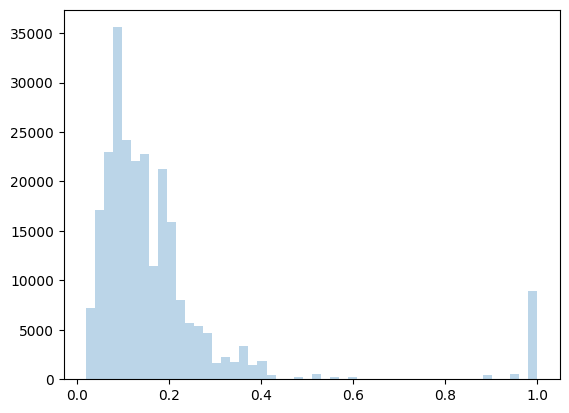

In [36]:
plt.hist(tanimoto_scores, bins=50, alpha=0.3)
plt.show()

In [47]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
chemicalspace = tsne.fit_transform(similarity_matrix)
#kmean = KMeans(n_clusters=5)
#kmean.fit(similarity_matrix)

The result shows that most molecules have a low similarity while a very high similarity

### Most common Murcko framework

In the following section the Murcko framework is used to show the structural diversity of the dataset. The Murcko framwork captures the "core" scaffold of a compound discharging all branches of a molecule. See explanation and examples here: https://datagrok.ai/help/datagrok/solutions/domains/chem/scripts/murcko-scaffolds

In [37]:
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from collections import Counter
from rdkit.Chem import Draw
from rdkit import Chem

In [38]:
c = Counter()
for mol in mols:
    scaffold_mol = GetScaffoldForMol(mol)
    scaffold_smiles = Chem.MolToSmiles(scaffold_mol)
    c[scaffold_smiles] += 1

In [39]:
c.most_common()

[('', 213),
 ('c1ccccc1', 177),
 ('c1cncnc1', 111),
 ('c1ccncc1', 47),
 ('c1ccc2c(c1)CCO2', 44),
 ('c1cnc2ccnn2c1', 31),
 ('c1ccc2ccccc2c1', 29),
 ('O=c1[nH]nnc2ccccc12', 19),
 ('O=C1NCCS1', 11),
 ('O=c1[nH]ncs1', 6),
 ('c1ccc(-n2cncn2)cc1', 6),
 ('O=c1[nH]c2ccccc2o1', 6),
 ('O=C1NC(=O)c2ccccc21', 5)]

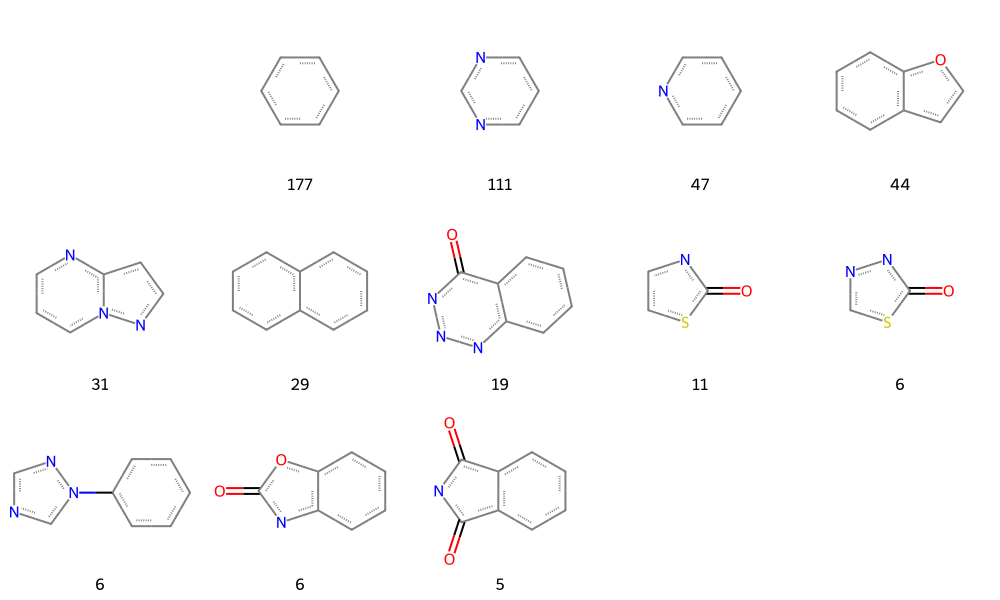

In [40]:
Draw.MolsToGridImage([Chem.MolFromSmarts(smarts) for smarts, count in list(c.most_common())], molsPerRow=5, legends=[str(count) for smarts, count in list(c.most_common())])

The result shows that there are only 12 different Murcko Frameworks in the dataset. The size of the dataset is 705.

### ERTL functional groups

In the following section you can find the most common functional groups in the dataset (ERTL functional group finder).

In [41]:
import sys
from rdkit import RDPaths
ifg_path = os.path.join(RDPaths.RDContribDir, "IFG")
sys.path.append(ifg_path)
import ifg

In [43]:
fgs = Counter()
for mol in mols:
    fgs_per_mol = ifg.identify_functional_groups(mol)
    seen_fgs = set()
    for fg in fgs_per_mol:
        atoms = fg.atoms
        if atoms not in seen_fgs:
            fgs[atoms] += 1
            seen_fgs.add(atoms)

In [44]:
fgs.most_common()

[('n', 201),
 ('OP(O)(O)=S', 199),
 ('N=C(O)O', 105),
 ('Cl', 99),
 ('OP(O)(=S)S', 93),
 ('O', 93),
 ('S', 87),
 ('N', 69),
 ('O=CO', 65),
 ('NC(=O)O', 56),
 ('nn', 43),
 ('O=[N+][O-]', 40),
 ('N=CO', 37),
 ('O=P(O)(O)OC=C(Cl)Cl', 36),
 ('OP(O)(=S)SCSP(O)(O)=S', 25),
 ('O=P(O)(O)OC=CCl', 21),
 ('nnn', 19),
 ('O=P(O)O', 18),
 ('N=C(O)O/N=C/S', 16),
 ('N#C\\C=N/OP(O)(O)=S', 16),
 ('NSNC(=O)O', 16),
 ('NP(=O)(O)O', 15),
 ('O=P(O)(S)N=CO', 14),
 ('C=NOC(=N)O', 13),
 ('O=C(S)NP(=O)(O)S', 11),
 ('NP(=O)(O)S', 10),
 ('O=C(NSNC(=O)ON=CS)ON=CS', 9),
 ('N=C(O)/C=C/OP(=O)(O)O', 8),
 ('O=P(O)(S)S', 8),
 ('s', 6),
 ('OP(=S)S', 6),
 ('o', 6),
 ('O=CN(C=O)CSP(O)(O)=S', 5),
 ('N=CN', 4),
 ('O=C(NSNC(=O)O/N=C/S)O/N=C/S', 3),
 ('O=P(O)(O)O\\C=C/Cl', 2)]

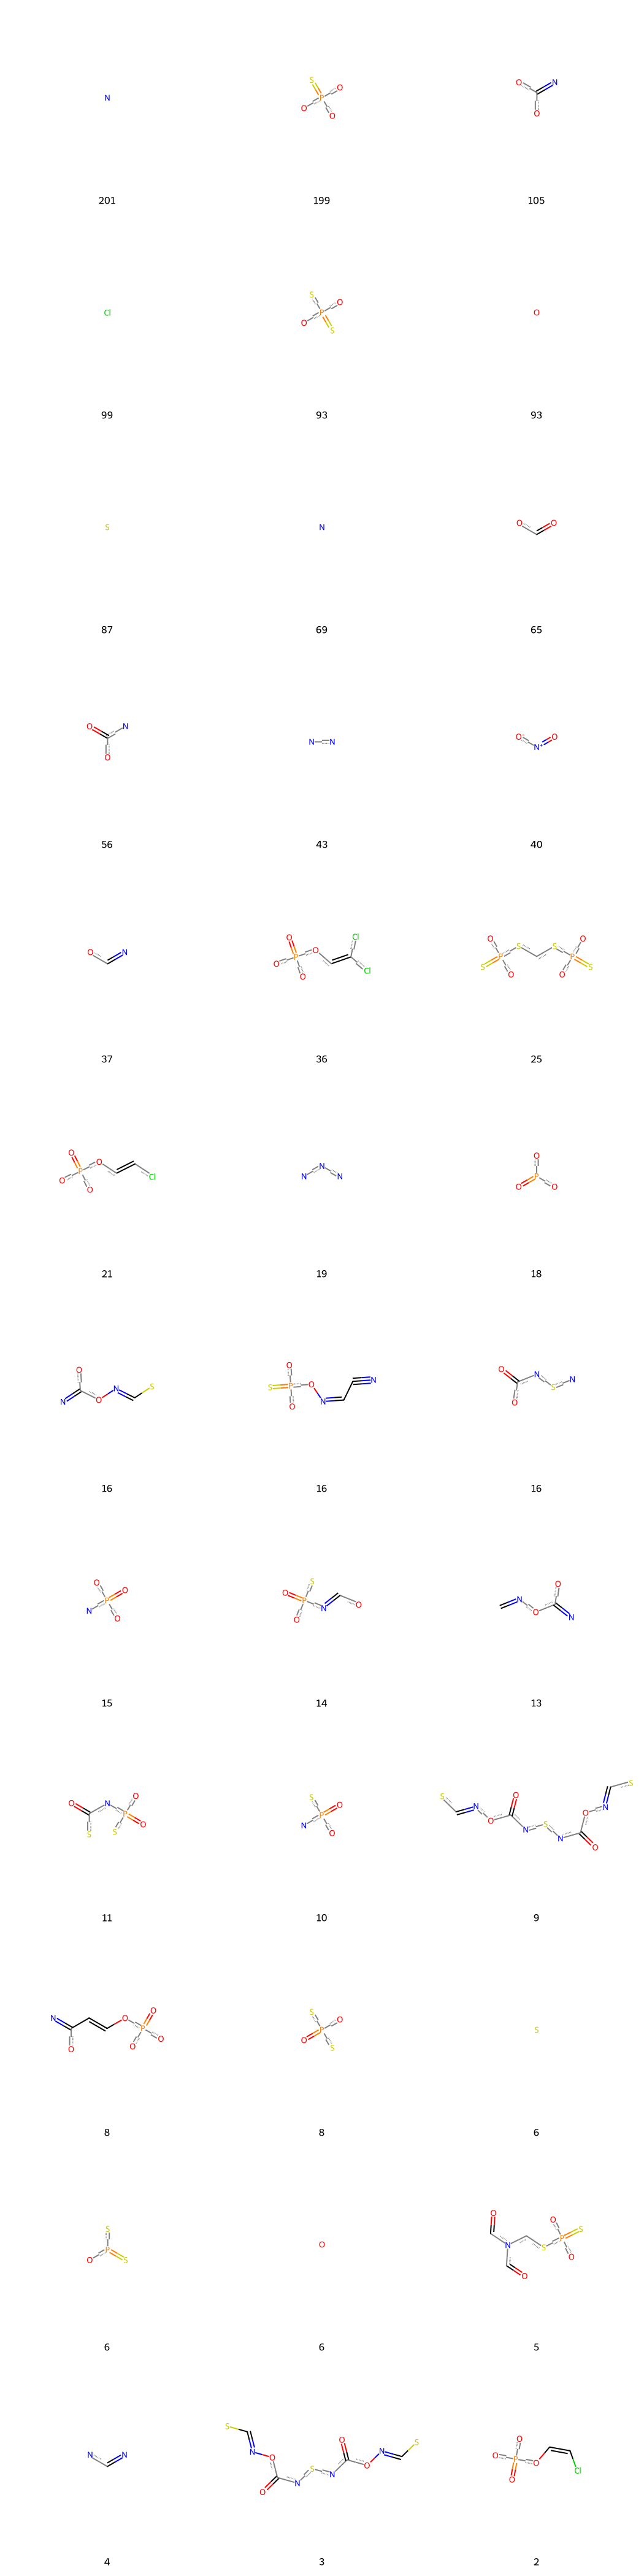

In [45]:
Draw.MolsToGridImage([Chem.MolFromSmarts(smarts) for smarts, count in list(fgs.most_common())], molsPerRow=3, legends=[str(count) for smarts, count in list(fgs.most_common())], subImgSize=(350, 350))

As one might release the dataset contains many organophosphate compounds and 

## Spectral Similarities

Check the similarities

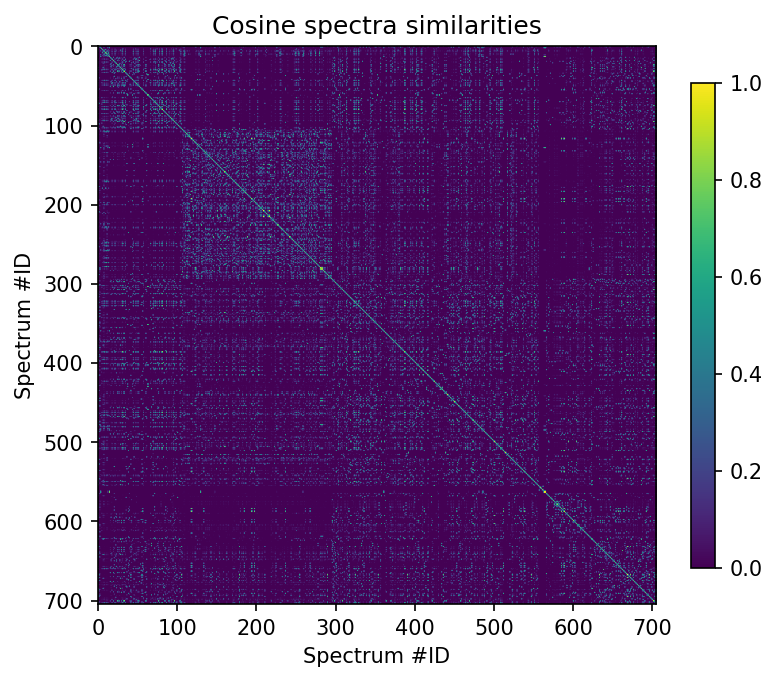

In [32]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
similarity_measure = CosineGreedy(tolerance=0.005)

# Calculate scores
scores = calculate_scores(spectra, spectra, similarity_measure, is_symmetric=True)

# Get score names
score_names = scores.score_names

# Convert sparse score array to Numpy array
scores_array = scores.scores.to_array()

# Extract the desired field for plotting
scores_array = scores_array['CosineGreedy_score']

# Plot the scores
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores_array, cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("Cosine spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
plt.show()

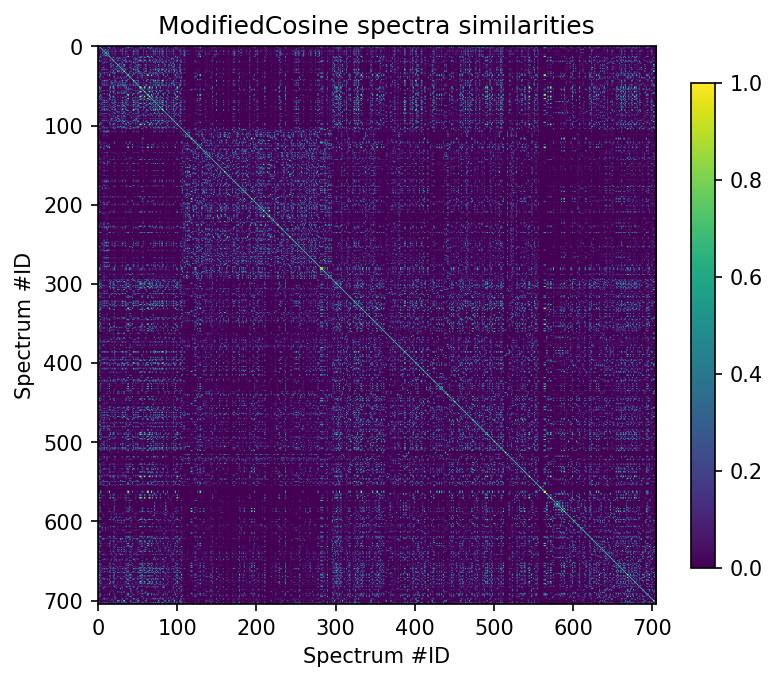

In [33]:
from matchms.similarity import ModifiedCosine

similarity_measure = ModifiedCosine(tolerance=0.005)

# Calculate scores
scores = calculate_scores(spectra, spectra, similarity_measure, is_symmetric=True)

# Get score names
score_names = scores.score_names

# Convert sparse score array to Numpy array
scores_array = scores.scores.to_array()

# Extract the desired field for plotting
scores_array = scores_array['ModifiedCosine_score']

# Plot the scores
plt.figure(figsize=(6,6), dpi=150)
plt.imshow(scores_array, cmap="viridis")
plt.colorbar(shrink=0.7)
plt.title("ModifiedCosine spectra similarities")
plt.xlabel("Spectrum #ID")
plt.ylabel("Spectrum #ID")
plt.show()

In [46]:
scores_list

[1.0,
 0.03790246485452385,
 0.013865142650772076,
 0.006206460052773881,
 0.16455669661880784,
 0.11074757841534696,
 0.860719354403472,
 0.0,
 0.3741683489475338,
 0.0187763645930294,
 0.1362950239001368,
 0.2096013697137977,
 0.0,
 0.06266225967776895,
 0.004095526705254182,
 0.038234929697888255,
 0.053424240167515125,
 0.14782904840998107,
 0.13452785616514812,
 0.030975430591018403,
 0.012045232491909766,
 0.43208548208925424,
 0.024998052138677607,
 0.16222377186340392,
 0.007238852905760169,
 0.10287311192250836,
 0.0,
 0.07173636355261738,
 0.8125303844703824,
 0.0002708868997013181,
 0.5987097737692074,
 0.4797692748357618,
 0.005714856156503994,
 0.018557558217810122,
 0.32252231961844907,
 0.029600096636016253,
 0.19396953444793086,
 0.0014795561121469676,
 0.008285341020868536,
 0.0033510197850087353,
 0.6932725307540767,
 0.0,
 0.007711263107288861,
 0.000921784522906194,
 0.4104012600383454,
 0.238494606498901,
 0.017549057892590366,
 0.35360998393629484,
 0.145237196180

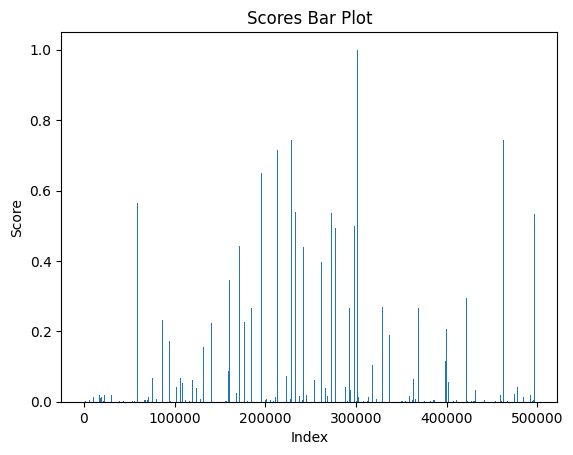

In [40]:
import matplotlib.pyplot as plt


# Create a bar plot
plt.bar(range(len(scores_list)), scores_list)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('Scores Bar Plot')

# Show the plot
plt.show()

In [39]:
scores_list = scores_array.flatten().tolist()
